. 

<font size=7>Opto Closed Loop Experiment Template

In this notebook we create the protocol for the opto close looop experiment. Make a copy of this template and the change the parameters to set up your specific experiment.

<font color="red"> **Before you run code** - Set key experiment variables below

In [3]:
maxwell_config = "/home/mxwbio/work/seizure_closed_loop/files/maxwell/configs/2023_05_08_hc52_hckcr1_A.cfg"
arduino_path="/dev/ttyACM10"

In [4]:
experiment_name = "2023_05_08_hc52_hckcr1_A"

# <font color="gray"> Set Up Notebook

Import required packages

In [5]:
import MaxwellGI as mgi
import time
import numpy as np
import matplotlib.pyplot as plt

## <font color="blue"> countSpikes

<font color="blue">countSpikes</font> is a function that counts the number of spikes that occure. Spike are counted over some set window of time, `count_window_seconds`. Spikes are continually counted throughout the duration of the experiment, `experiment_length_seconds`. All the spike counts that were recorded are then returned to the user.

In [6]:
def countSpikes( experiment_length_seconds, count_window_seconds=10 ):
    print("starting devices")
    maxwell = mgi.MaxwellCtl( config= maxwell_config )          # Turn Maxwell On
    stream  = mgi.Streamer( maxwell, filtered=False )           # Start Livestream
    
    print("Starting experiment")
    experiment_end = time.time() + experiment_length_seconds                                  
    first_time = True
    spike_counts = []
    while time.time() < experiment_end:                                  # while the experiment hasn't reached it's final run length
        count_time = time.time() + count_window_seconds                  # Count spikes over the count window length
        spike_count = 0                                                  # continually add new spikes to spike_count
        
        while time.time() < count_time:                                  # for our specified count winow length
            frameID, voltages, spikes = stream.getData()                 # get spikes data
            for spike in spikes:                                         # add up all of the spikes to spike_count
                spike_count += 1
        print("Spike Count: ", spike_count )    
        if not first_time:                                              # We don't record the first spike count, because that value is often wonky
            spike_counts.append(spike_count)                            # but we record the rest of the spike counts
        first_time = False

    
    print("Experiment over. Shutting down devices")
    del stream                # Stop Stream
    print("done")
    return spike_counts

## <font color="blue">optoRecording

In [7]:
def optoRecording( light_on_seconds, light_off_seconds, num_pulses, light_intensity,
                       calibration_file, data_file, log_file ):
    
    maxwell = mgi.MaxwellCtl( config=maxwell_config)                                       # Turn Maxwell On
    opto_ctl = mgi.OptoCtl( log_file=log_file , 
                       calibration_file=calibration_file, arduino_path=arduino_path)       # Set up Opto
    maxwell.recordingStart( data_file=data_file)                                           # Start recording data             

    print("Starting experiments")
    time.sleep(30)
    print("Light On")
    opto_ctl.pulses(  on_duration=light_on_seconds*1000, off_duration=light_off_seconds*1000, num_pulses=num_pulses, intensity=light_intensity)
    print("Light Off")
    time.sleep(40)

    # Shut Down Experiment
    print("shutting down devices")
    opto_ctl.close()          # Stop Opto
    maxwell.recordingStop()  # stop recording
    print("done")


## <font color="blue"> optoIntensitySweep

In [8]:
def optoIntensitySweep( light_on_seconds, calibration_file, data_file, log_file ):

    maxwell = mgi.MaxwellCtl( config=maxwell_config)                                       # Turn Maxwell On
    opto_ctl = mgi.OptoCtl( log_file=log_file , 
                       calibration_file=calibration_file, arduino_path=arduino_path)       # Set up Opto
    maxwell.recordingStart( data_file=data_file)                                           # Start recording data             

    print("Starting experiments")
    time.sleep(20)
    for light in [.1,.2,.3,.4,.5,.6,.7,.8,.9]:
        print("Intensity: ",light)
        print("Light On")
        opto_ctl.pulses(  on_duration=light_on_seconds*1000, off_duration=100, num_pulses=1, intensity=light)
        print("Light Off")
        time.sleep(30)
    time.sleep(30)
    
    # Shut Down Experiment
    print("Experiment finished. shutting down devices")
    opto_ctl.close()          # Stop Opto
    maxwell.recordingStop()  # stop recording
    print("done")


## <font color="blue">optoClosedLoop 

In [17]:
def optoClosedLoop( experiment_length_seconds, count_window_seconds, spike_threshold, light_on_seconds, light_intensity,
                    calibration_file, data_file, log_file  ):
    
    ### Set up Maxwell and Opto
    maxwell = mgi.MaxwellCtl( config=maxwell_config)                                       # Turn Maxwell On
    stream  = mgi.Streamer( maxwell, filtered=False )                                      # Start Livestream
    opto_ctl = mgi.OptoCtl( log_file=log_file , 
                       calibration_file=calibration_file, arduino_path=arduino_path)       # Set up Opto
    maxwell.recordingStart( data_file=data_file)                                           # Start recording data                

    # Define Closed Loop Experiment
    print("Starting closed loop")
    last_opto = 0
    first_time = True
    spike_counts=[]
    experiment_end = time.time() + experiment_length_seconds             # End the experiment in 20 seconds
    while time.time() < experiment_end:                                  # while the experiment hasn't run for 20 seconds
        count_time = time.time() + count_window_seconds                  # Count spikes over 1 second window
        spike_count = 0                                                  # continually add new spikes to spike_count
        while time.time() < count_time:                                  # while still in 1 second window
            frameID, voltages, spikes = stream.getData()                 # get spikes data
            for spike in spikes:                                         # if there's a spike add it to the spike_count
                spike_count += 1
        print("Spike Count: ", spike_count )    
        spike_counts.append(spike_count) 
    
        if spike_count > spike_threshold and time.time()>last_opto+light_on_seconds+5  and not first_time:           # If tehre are more than 10 spikes in a second
            print("Starting Opto Pulses")                                              # Do some opto pulses
            opto_ctl.pulses(  on_duration=light_on_seconds*1000, off_duration=100, num_pulses=1, intensity=light_intensity )
            print("finished pulses")
            #print("emptying artifact spikes")
            last_opto = time.time()
            #empty_time = time.time()+10                                  # wait 10 second to empty out previous data from stream
            #while time.time() < empty_time:
            #    stream.getData()                                         # Empty out stream data, because pulses created many fake spikes
            #print("finished emptying")
        first_time = False
        
    print("experiment finished")    
    #time.sleep(120)
    
    # Shut Down Experiment
    print("shutting down devices")
    del stream                # Stop Stream
    opto_ctl.close()          # Stop Opto
    maxwell.recordingStop()  # stop recording
    print("done")
    return spike_counts

# <font color="purple"> Experiment: Opto Intensity Sweep

## <font color="purple">Run Experiment

In [10]:
optoIntensitySweep( light_on_seconds=10,
                    log_file= f"./files/opto/logs/{experiment_name}_0",
                    calibration_file= "./files/opto/calibrations/20230308T140514-ucsf-opto-system-b_real-530nm-1a-v1.csv",
                    data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_0.h5" )

MaxOne initialized
Available USB devices:
('ASRL/dev/ttyACM10::INSTR',)
recording_filename 20230508T144735-2023_05_08_hc52_hckcr1_A_0
stim_log_file: ./files/opto/logs/20230508T144735-2023_05_08_hc52_hckcr1_A_0_opto_stim_log.csv
CSV file is 0
Recording Started
Starting experiments
Intensity:  0.1
Light On
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.1 	 delay/on/off (frames): 0 / 200000 / 2000
Light Off
Intensity:  0.2
Light On
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.2 	 delay/on/off (frames): 0 / 200000 / 2000
Light Off
Intensity:  0.3
Light On
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.3 	 delay/on/off (frames): 0 / 200000 / 2000
Light Off
Intensity:  0.4
Light On
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.4 	 delay/on/off (frames): 0 / 200000 / 2000
Light Off
Intensity:  0.5
Light On
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 2000
Light Off
Intensity:  0.6
Light On
Stim pulse 	 use_maxwell

## <font color="purple">Document experiment

<font color="red">Use the markdown below to document your experiment

**Experiments**

* Experiment_name - text about what you did


# <font color="purple"> Experiment: Opto <font color="green">Green</font> Light

## <font color="purple">Run Experiment

In [ ]:
optoRecording( light_on_seconds=10, light_off_seconds=30, num_pulses=3, intensity=int("__TBD___"),
                calibration_file= "./files/opto/calibrations/20230308T140514-ucsf-opto-system-b_real-530nm-1a-v1.csv",
                data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_1.h5",
                log_file = f"./files/opto/logs/{experiment_name}_1")

## <font color="purple">Document experiment

<font color="red">Use the markdown below to document your experiment

**Experiments**

* Experiment_name - {number}hz {color} light pulse, with {numbers} second pause in between
    * calibration file - ?
    * recording file - ?

# <font color="purple"> Experiment: Opto <font color="red">Red</font> Light

## <font color="purple">Run Experiment

In [ ]:
optoRecording( light_on_seconds=10, light_off_seconds=30, num_pulses=3, intensity=int("__TBD___"),
                calibration_file= "./files/opto/calibrations/20230203T152939-ucsf-opto-system-a_real-625nm-1a-v1.csv",
                data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_2.h5",
                log_file = f"./files/opto/logs/{experiment_name}_2")

## <font color="purple">Document experiment

<font color="red">Use the markdown below to document your experiment

**Experiments**

* Experiment_name - {number}hz {color} light pulse, with {numbers} second pause in between
    * calibration file - ?
    * recording file - ?

# <font color="purple"> Experiment: Opto <font color="blue">Blue</font> Light

## <font color="purple">Run Experiment

In [ ]:
optoRecording( light_on_seconds=10, light_off_seconds=30, num_pulses=3, intensity=int("__TBD___"),
                calibration_file= "./files/opto/calibrations/20230203T153451-ucsf-opto-system-b_real-470nm-1a-v1.csv",
                data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_3.h5",
                log_file = f"./files/opto/logs/{experiment_name}_3")

## <font color="purple">Document experiment

<font color="red">Use the markdown below to document your experiment

**Experiments**

* Experiment_name - {number}hz {color} light pulse, with {numbers} second pause in between
    * calibration file - ?
    * recording file - ?

# <font color="purple"> Experiment: Count Spikes

## <font color="purple">Run Experiment

In [12]:
spike_counts = countSpikes(90)

starting devices
MaxOne initialized
maxwell streamer ready
Starting experiment
Spike Count:  79
Spike Count:  70
Spike Count:  95
Spike Count:  112
Spike Count:  90
Spike Count:  88
Spike Count:  85
Spike Count:  109
Spike Count:  109
Experiment over. Shutting down devices
done


## <font color="purple">Analyze Results

Plot histogram of spikes

Mean Spikes:  94.75


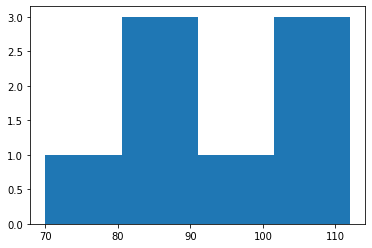

In [13]:
print("Mean Spikes: ", np.mean(spike_counts) )
plt.hist(spike_counts, bins='auto')  # arguments are passed to np.histogram
plt.show()

Save Data

In [14]:
np.savetxt( experiment_name+"_calibrate_spike_counts.csv", spike_counts, delimiter="," )
#checkit = np.loadtxt("some_experiment_spike_counts.csv")   # How to load data

## <font color="purple">Document experiment

<font color="red">Use the markdown below to document your experiment

**Experiments**

* Experiment 1 - text about what you did
    * experiment_length_seconds=?, count_window_seconds=?, csv_file=?

# <font color="purple"> Experiment: Closed Loop - No Bicuculine

## <font color="purple">Run Experiment

In [18]:
spike_counts = optoClosedLoop( experiment_length_seconds= 60,
                count_window_seconds=10,
                spike_threshold= 90, #int("???"),
                light_on_seconds= 10,
                light_intensity= .5,  #int("???"),
                calibration_file= "./files/opto/calibrations/20230308T140514-ucsf-opto-system-b_real-530nm-1a-v1.csv",
                data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_5.h5",
                log_file=  f"./files/opto/logs/{experiment_name}_5" )

MaxOne initialized
maxwell streamer ready
Available USB devices:
('ASRL/dev/ttyACM10::INSTR',)
recording_filename 20230508T150037-2023_05_08_hc52_hckcr1_A_5
stim_log_file: ./files/opto/logs/20230508T150037-2023_05_08_hc52_hckcr1_A_5_opto_stim_log.csv
CSV file is 0
Recording Started
Starting closed loop
Spike Count:  99
Spike Count:  124
Starting Opto Pulses
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 2000
finished pulses
Spike Count:  404
Spike Count:  118
Starting Opto Pulses
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 2000
finished pulses
Spike Count:  265
Spike Count:  84
experiment finished
shutting down devices
Recording finished
done


In [ ]:
np.savetxt( experiment_name+"_no_bicuculine_spike_counts.csv", spike_counts, delimiter="," )

## <font color="purple">Document experiment

<font color="red">Use the markdown below to document your experiment

**Experiments**

* Experiment 1 - text about what you did
    * experiment_length_seconds=?, count_window_seconds=?, csv_file=?

# <font color="purple"> Experiment: Closed Loop - <font color="red">Bicuculine

## <font color="purple">Run Experiment

Name variables

In [25]:
experiment_length_seconds = 120
count_window_seconds = 10
spike_threshold  = 270 
light_intensity  = .5
calibration_file = "./files/opto/calibrations/20230308T140514-ucsf-opto-system-b_real-530nm-1a-v1.csv"
data_file = f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_7.h5"
log_file  = f"./files/opto/logs/{experiment_name}_7" 

In [26]:
light_on_seconds = 10

Start recording

In [27]:
### Set up Maxwell and Opto
maxwell = mgi.MaxwellCtl( config=maxwell_config)                                       # Turn Maxwell On
stream  = mgi.Streamer( maxwell, filtered=False )                                      # Start Livestream
opto_ctl = mgi.OptoCtl( log_file=log_file , 
                    calibration_file=calibration_file, arduino_path=arduino_path)       # Set up Opto
maxwell.recordingStart( data_file=data_file)                                           # Start recording data                


MaxOne initialized
maxwell streamer ready
Available USB devices:
('ASRL/dev/ttyACM10::INSTR',)
recording_filename 20230508T151131-2023_05_08_hc52_hckcr1_A_7
stim_log_file: ./files/opto/logs/20230508T151131-2023_05_08_hc52_hckcr1_A_7_opto_stim_log.csv
CSV file is 0
Recording Started


right after bicuculinw is added, run closed loop

In [28]:
# Define Closed Loop Experiment
print("Starting closed loop")
last_opto = 0
first_time = True
spike_counts=[]
experiment_end = time.time() + experiment_length_seconds             # End the experiment in 20 seconds
while time.time() < experiment_end:                                  # while the experiment hasn't run for 20 seconds
    count_time = time.time() + count_window_seconds                  # Count spikes over 1 second window
    spike_count = 0                                                  # continually add new spikes to spike_count
    while time.time() < count_time:                                  # while still in 1 second window
        frameID, voltages, spikes = stream.getData()                 # get spikes data
        for spike in spikes:                                         # if there's a spike add it to the spike_count
            spike_count += 1
    print("Spike Count: ", spike_count )    
    spike_counts.append(spike_count) 
    
    if spike_count > spike_threshold and time.time()>last_opto+light_on_seconds+5  and not first_time:           # If tehre are more than 10 spikes in a second
        print("Starting Opto Pulses")                                              # Do some opto pulses
        opto_ctl.pulses(  on_duration=light_on_seconds*1000, off_duration=100, num_pulses=1, intensity=light_intensity )
        print("finished pulses")
            #print("emptying artifact spikes")
        last_opto = time.time()
            #empty_time = time.time()+10                                  # wait 10 second to empty out previous data from stream
            #while time.time() < empty_time:
            #    stream.getData()                                         # Empty out stream data, because pulses created many fake spikes
            #print("finished emptying")
    first_time = False
        
print("experiment finished")    
#time.sleep(120)

Starting closed loop
Spike Count:  2228
Spike Count:  83
Spike Count:  96
Spike Count:  67
Spike Count:  76
Spike Count:  85
Spike Count:  106
Spike Count:  90
Spike Count:  95
Spike Count:  87
Spike Count:  89
Spike Count:  77
experiment finished


stop experiment

In [29]:
# Shut Down Experiment
print("shutting down devices")
del stream                # Stop Stream
opto_ctl.close()          # Stop Opto
maxwell.recordingStop()  # stop recording
print("done")

shutting down devices
Recording finished
done


## <font color="purple">Document experiment

<font color="red">Use the markdown below to document your experiment

**Experiments**

* Experiment_name -